# Applications of Data Science
# Lab 2
# Exploring Kriging of Spatial Data

## Overview
In this lab you will work with heavy metal pollution data, sampled from the delta of the Meuse River in Belgium. The values of metal concentrations are sampled at certain spatial points. The spatial sampling is not performed on a close-spaced regular grid. Therefore, spatial interpolation or kriging is used to create a map of the expected concentration of metal pollution. Specifically, you will: 

- Load and examine the properties of these data.
- Explore the spatial dependency using the variogram of the metal pollution data.
- Use kriging to interpolate and create a map of metal pollution.

## What you will need
To complete this lab, you will need the following:
- A web browser and Internet connection
- The lab files for this lab

****
**Note** To set up the required environment for the lab, follow the instructions in the Setup document.
****

## Load and Examine the Data
As a first step, execute the code below to load the metal pollution data set, and examine its contents. Execute the code in the cell below to have a first look at these data. 

In [ ]:
install.package()

In [2]:
library(sp)
data(meuse)
names(meuse)

Warning message:
"package 'sp' was built under R version 3.4.3"

[1] "x"       "y"       "cadmium" "copper"  "lead"    "zinc"    "elev"   
 [8] "dist"    "om"      "ffreq"   "soil"    "lime"    "landuse" "dist.m"

The **meuse** data frame has the columns shown above. In particular, note the **x** and **y** columns that indicate location, and columns with the names of the metals. 

Next, find the class of the **meuse** data frame, by exectuing the code in the cell below.

In [3]:
class(meuse)

[1] "data.frame"

The **meuse** data frame is an ordinary data frame. 

The code below converts the ordinary data frame to a spatial data frame, in two steps. The first adds a **coordinates** attribute to the data frame. The second step adds a projection string to the data frame. 

Execute the code in the cell below to convert the **meuse** data frame to a spatial data frame.

In [4]:
set.coords = function(df){
  require(sp)
  # Function converts dataframe to spatialpointsdataframe
  # Convert to spatial points data frame
  coordinates(df) = ~x+y 

  # Assign the datum and compute the lat-lon of the 
  # of the x-y coordinates
  proj4string(df) <- CRS("+proj=stere
   +lat_0=52.15616055555555 +lon_0=5.38763888888889
   +k=0.999908 +x_0=155000 +y_0=463000
   +ellps=bessel +units=m +no_defs
   +towgs84=565.2369,50.0087,465.658,
   -0.406857330322398,0.350732676542563,-1.8703473836068, 4.0812")
  df
}
meuse = set.coords(meuse)

With the spatial attributed added, the **meuse** data frame is now of class **SpatialPointsDataFrame**.

To view a summary of this data frame, exectue the code in the cell below. 

In [5]:
summary(meuse)

Object of class SpatialPointsDataFrame
Coordinates:
     min    max
x 178605 181390
y 329714 333611
Is projected: TRUE 
proj4string :
[+proj=stere +lat_0=52.15616055555555 +lon_0=5.38763888888889
+k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs
+towgs84=565.2369,50.0087,465.658,
-0.406857330322398,0.350732676542563,-1.8703473836068, 4.0812]
Number of points: 155
Data attributes:
    cadmium           copper            lead            zinc       
 Min.   : 0.200   Min.   : 14.00   Min.   : 37.0   Min.   : 113.0  
 1st Qu.: 0.800   1st Qu.: 23.00   1st Qu.: 72.5   1st Qu.: 198.0  
 Median : 2.100   Median : 31.00   Median :123.0   Median : 326.0  
 Mean   : 3.246   Mean   : 40.32   Mean   :153.4   Mean   : 469.7  
 3rd Qu.: 3.850   3rd Qu.: 49.50   3rd Qu.:207.0   3rd Qu.: 674.5  
 Max.   :18.100   Max.   :128.00   Max.   :654.0   Max.   :1839.0  
                                                                   
      elev             dist               om         ff

Examine this summary noting the following:

- The coordinates of the points are now attributes of the data frame, along with the projection string.
- There are 4 columns showing the concentration of heavy metals at the spatial sample points.
- Other values in the data frame include **dist** giving the distance to the Meuse River.

## Loading the Grid Data

In order to interpolate the metal pollution data to a grid, you must supply a spatial grid to interpolate to. The **meuse.grid** data frame contains just such a grid. Execute the code in the cell below to load the grid data and examine its class. 

In [6]:
data(meuse.grid)
class(meuse.grid)

[1] "data.frame"

This data frame must be converted to a spatial data frame class. The code below performs two operations. First, the **set.coords** function is used again to add coordinate attributes to the data frame, creating a spatial data frame. Second, since the points are on a regular grid, the gridded attribute is set to TRUE.

Execute the code in the cell below to create a SpatialPixelsDataFrame.

In [7]:
meuse.grid = set.coords(meuse.grid)
gridded(meuse.grid) = TRUE

A SpatialPixelsDataFrame is distigushed by having the spatial cordinates at the center of a 'pixel'. 

Execute the code in the cell below to produce a summary of the SpatialPixelsDataFrame. 

In [8]:
summary(meuse.grid)

Object of class SpatialPixelsDataFrame
Coordinates:
     min    max
x 178440 181560
y 329600 333760
Is projected: TRUE 
proj4string :
[+proj=stere +lat_0=52.15616055555555 +lon_0=5.38763888888889
+k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs
+towgs84=565.2369,50.0087,465.658,
-0.406857330322398,0.350732676542563,-1.8703473836068, 4.0812]
Number of points: 3103
Grid attributes:
  cellcentre.offset cellsize cells.dim
x            178460       40        78
y            329620       40       104
Data attributes:
     part.a           part.b            dist        soil     ffreq   
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000   1:1665   1: 779  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.1193   2:1084   2:1335  
 Median :0.0000   Median :1.0000   Median :0.2715   3: 354   3: 989  
 Mean   :0.3986   Mean   :0.6014   Mean   :0.2971                    
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:0.4402                    
 Max.   :1.0000   Max.   :1.0000   Max.   :0

The SpatialPixelDataFrame has the same coordinate attributes seen in the **meuse** data frame. This SpatialPixelDataFrame contains some other columns which are shown. 

## Plot the Metal Concentration

Now that you have loaded and examined the data set, you will create spatial maps of the sampled concentrations of the metals. The code below uses a bubble plot, where the size of the bubble corresponds to a numeric value. 

Execute the code in the cell below to plot the spatial concentration of each of the metals.

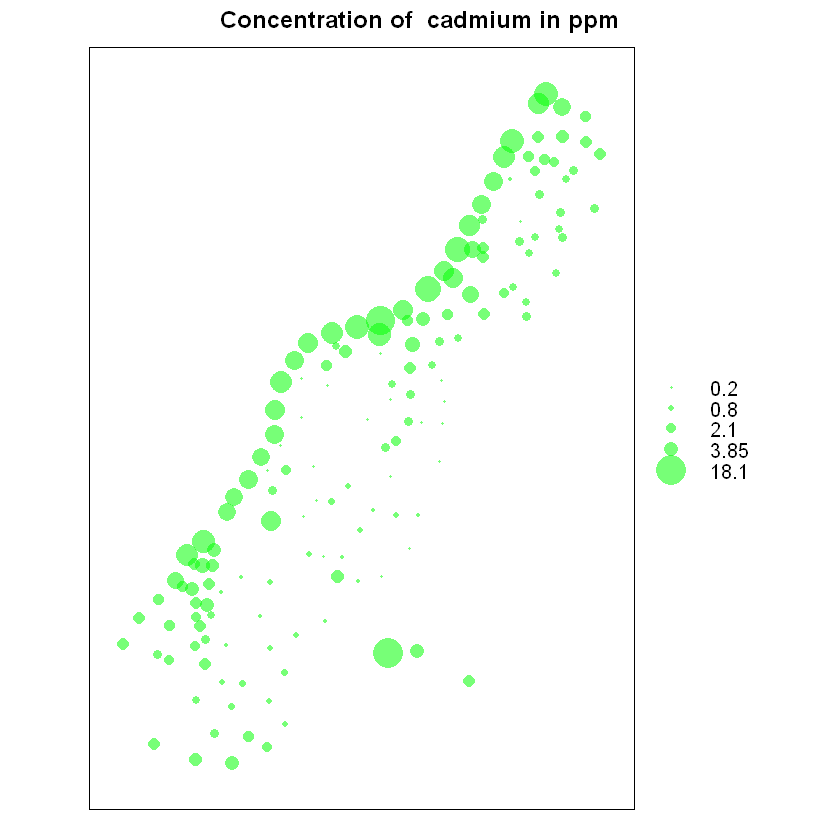

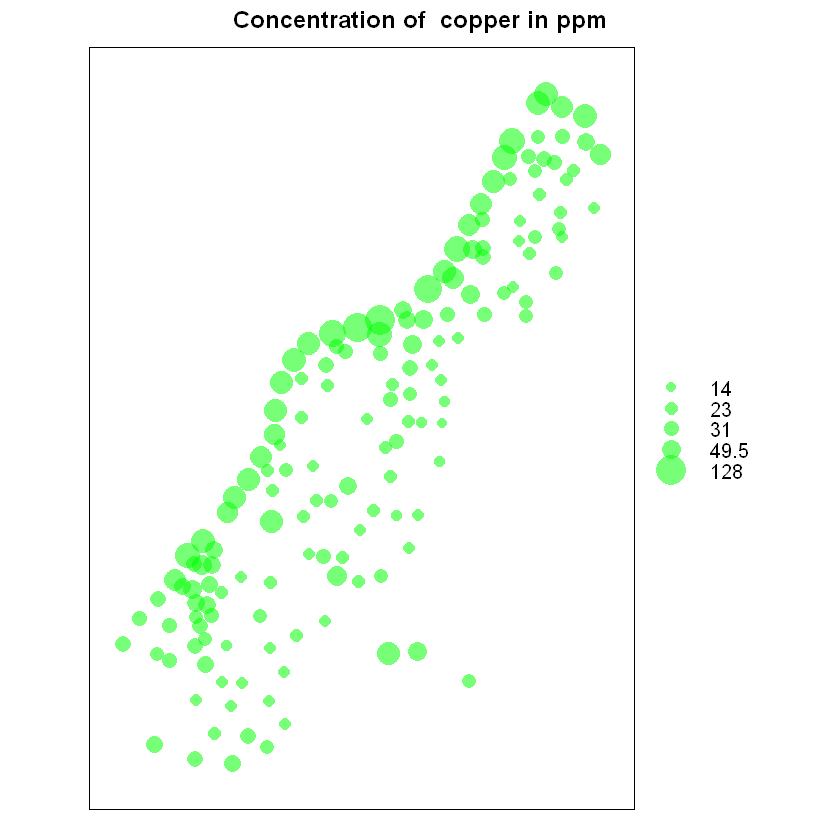

[[1]]

[[2]]

[[3]]

[[4]]


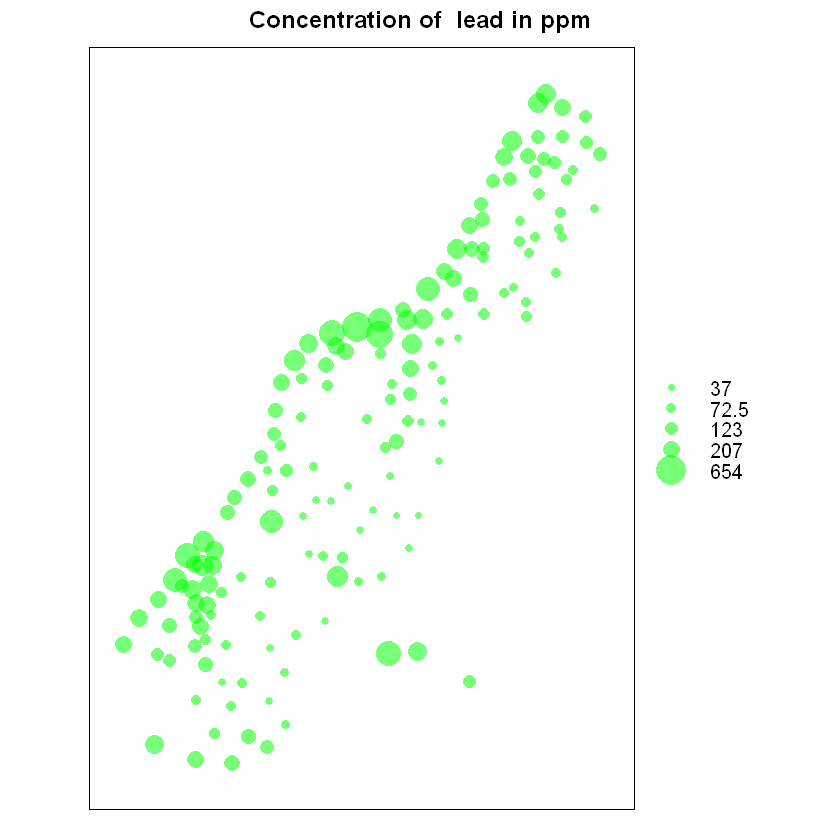

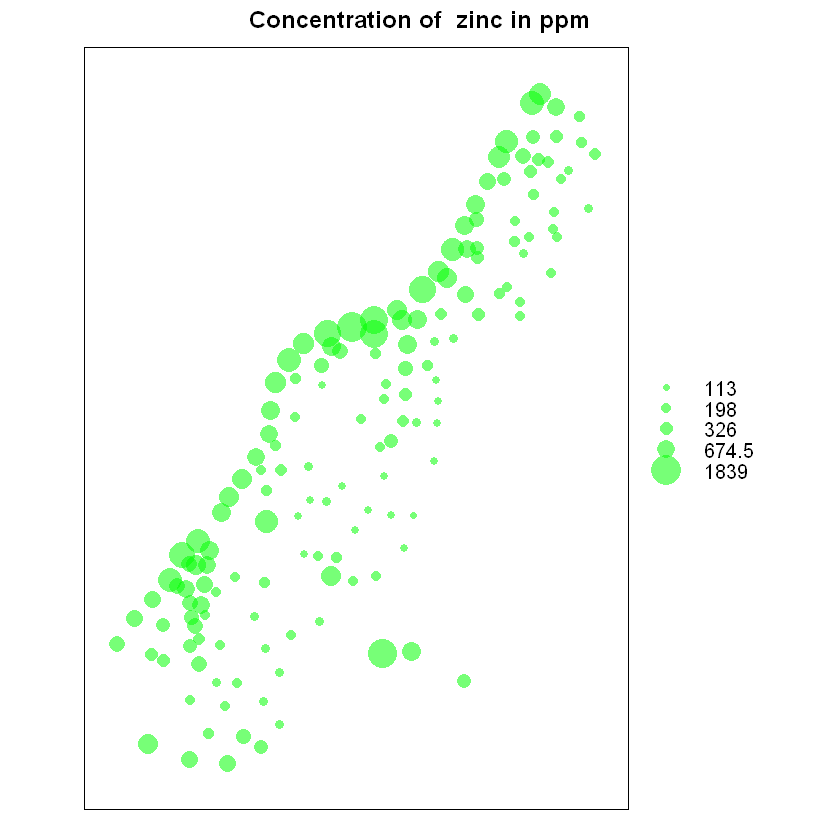

In [9]:
cols = c('cadmium', 'copper', 'lead', 'zinc')
plot.bubble = function(x){
  Title = paste('Concentration of ', x, 'in ppm')
  bubble(meuse, x,col=c("#00ff0088", "#00ff0088"), main = Title)
}
par(mar = c(0.7,0.7,0.7,0.7))
lapply(cols, plot.bubble)

Examine these plots noticing the following:

- The distribution of sample points is far from uniform in space. The most dense sampling occurs along the path of the Meuse River, running from the upper right to the lower left of the diagram.
- The distribution of metal concentration is not uniform in space. The highest concentration occurs along the path of the Meuse River. This seems reasonable, since the metals are likely carried by the river. 

## The Variogram

Next, you will explore the spatial dependency structure of the metal concentarion using variogram methods. 

It appears from the maps that the greatest concentration of the metal pollutants is near the river. Therefore, you will use the distance from the river, in the **dist** column, to compute spatial dependency. 

As a first step you will  plot the concentration of copper versus the distance from the river, by executing the code in the cell below. 

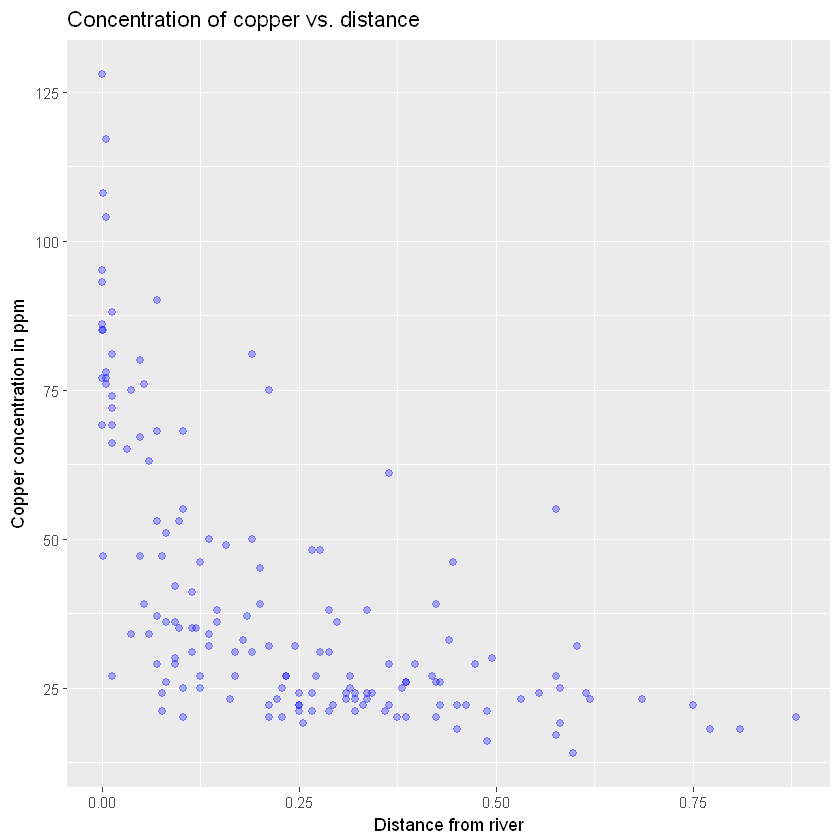

In [11]:
require(ggplot2)
ggplot(data.frame(meuse), aes(dist, copper)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3)+
  ggtitle('Concentration of copper vs. distance') +
  ylab('Copper concentration in ppm') +
  xlab('Distance from river')

Examine these data. The relationship between copper concentration and distance from the river is far from linear. 

As a next step in this exploration, plot log of copper concentration vs distance to the river by executing the code in the cell below. 

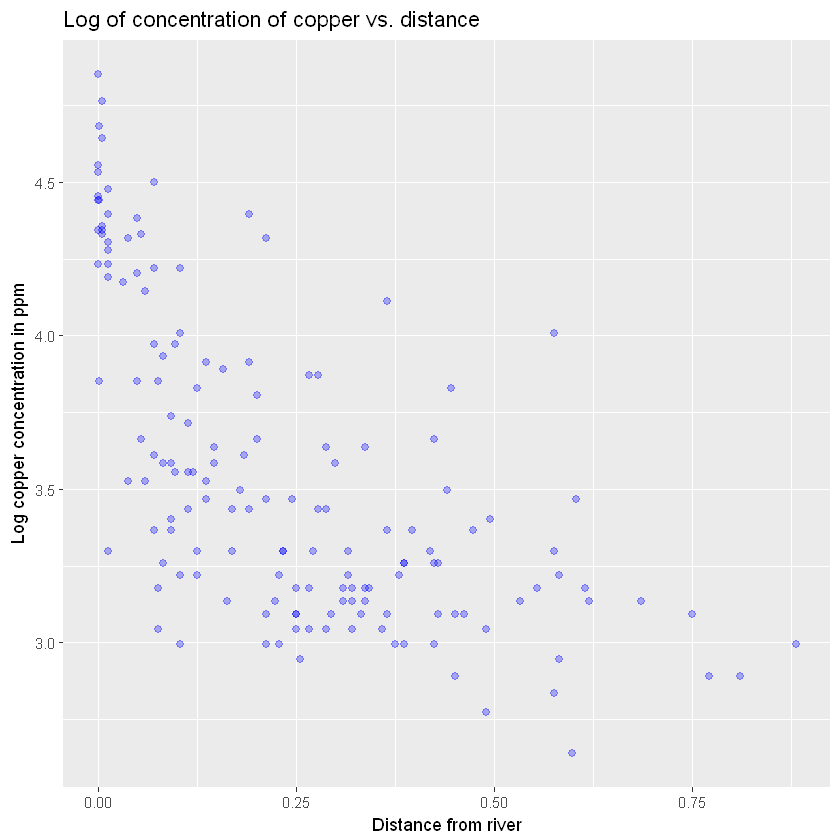

In [12]:
meuse$logCopper = log(meuse$copper)
ggplot(data.frame(meuse), aes(dist, logCopper)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3) +
  ggtitle('Log of concentration of copper vs. distance') +
  ylab('Log copper concentration in ppm') +
  xlab('Distance from river')

The relationship between log of copper concentration versus distance from the river looks closer to linear. However, this relationship is still not linear.

Next, try plotting log of copper concentration versus the square root of distance from the river by executing the code in the cell below. 

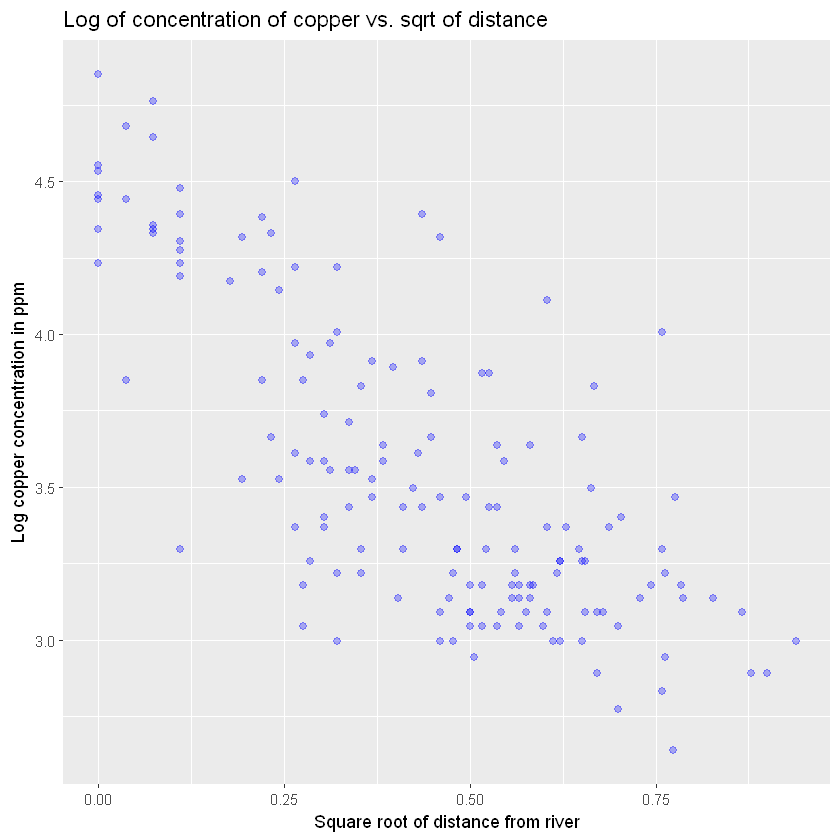

In [13]:
meuse$sqrtDist = sqrt(meuse$dist)
ggplot(data.frame(meuse), aes(sqrtDist, logCopper)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3)+
  ggtitle('Log of concentration of copper vs. sqrt of distance') +
  ylab('Log copper concentration in ppm') +
  xlab('Square root of distance from river')

Examine the plot shown above. The relationship between log of copper concentration and square root of distance from the river is close to linear. 

Having established a relationship between copper concentration and distance from the river you are now ready to compute the variogram. The code in the cell below computes a variogram model and fits it to the data. Execute this code. 

(**Note**: If an error occurs stating that variogram can't be found, save the notebook, halt and close it, reopen it, run all the cells above this one, and then re-run the cell below - occasionally newly installed packages fail to load in a timely fashion) 

In [15]:
#install.packages('gstat')
library(gstat)
#require(gstat)
copper.vgm = variogram(logCopper ~ sqrtDist, meuse)
copper.vgm.fit = fit.variogram(copper.vgm, model = vgm(1, "Sph", 900, 1))

Warning message:
"package 'gstat' was built under R version 3.4.3"

Now, plot the variogram to get a feel for its behavior by executing the code in the cell below.

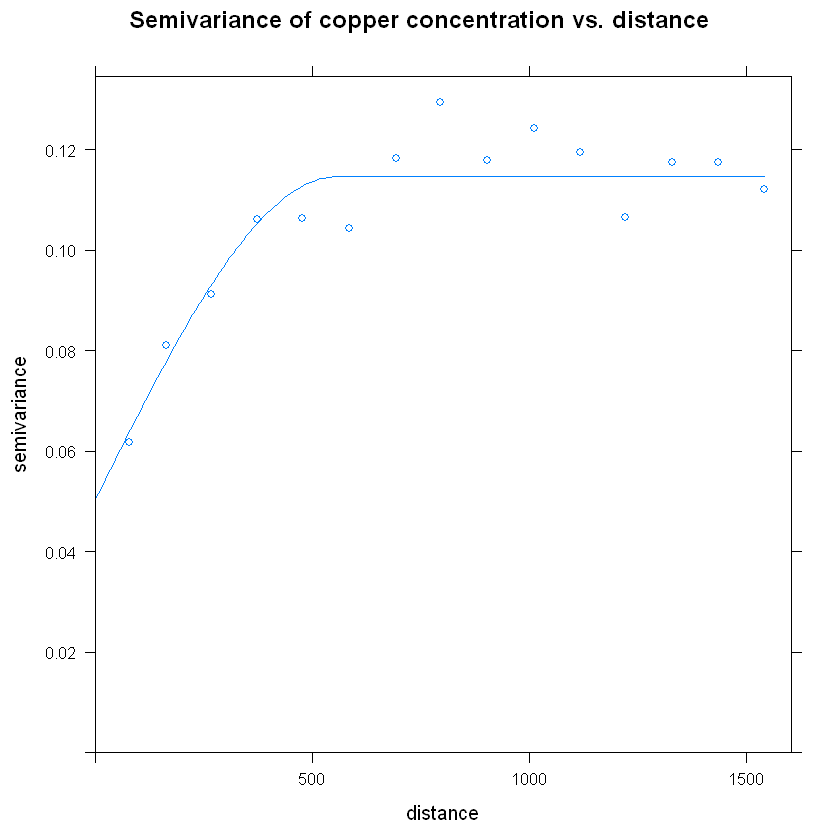

In [16]:
plot(copper.vgm, copper.vgm.fit, main = "Semivariance of copper concentration vs. distance")

In [ ]:
plot(copper.vgm, copper.vgm.fit, main = "Semivariance of copper concentration vs. distance")

Examine this plot. The semivariance versus distance relationship shows a reasonably good fit. Notice semivariance increases rapidly up to about 500 meters and then levels out thereafter. 

The semivariogram was computed using orthoginal distance from the river. However, there can be a dependancy structure in spatial at any direction. To investigate this relationship, execute the code in the cell below. 

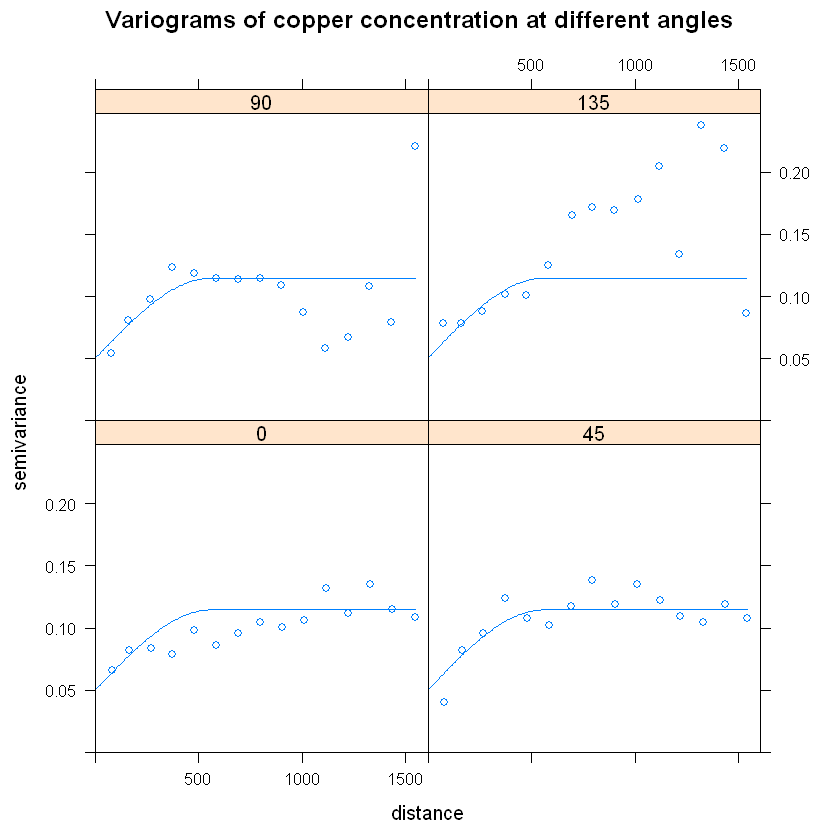

In [17]:
copper.vgm.dir = variogram(logCopper ~ sqrtDist, meuse, alpha = c(0, 45, 90, 135))
plot(copper.vgm.dir, copper.vgm.fit, main = 'Variograms of copper concentration at different angles')

Examine the plots of the semivariance versus distance at the angles of 0, 45, 90 and 135 degrees. Notice that the fit is good at 0 and 45 degrees. Not too surprisingly, the fit at 90 and 135 degrees is not particularly good.

Having computed and examined the variogram, you will now make a map of the semivariance. the code in the cell below computes a variogram with the **map = TRUE** argument. Execute the code in the cell below to display the map. 

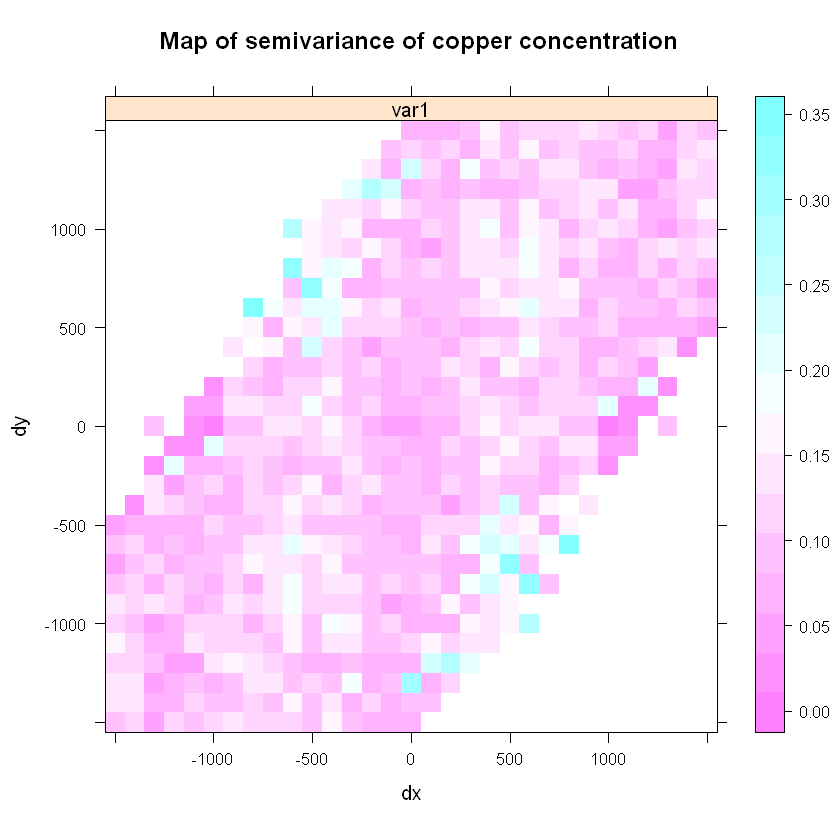

In [18]:
copper.vgm.map = variogram(logCopper ~ sqrtDist, meuse, cutoff = 1500, width = 100, map = TRUE)
plot(copper.vgm.map, threshold = 5, main = "Map of semivariance of copper concentration")

Examine this map. Most of the map is dominated by areas of low semivariance with just a few areas of high semivariace.  


****
#### Exercise

You must now compute and evaluate the vairogram of log of zinc concentration versus the square root of distance to answer the following questions:
- Is there a reasonably linear relationship between log of zinc concentration and square root of distance?
    
    ANS: Not very linear. Looks a little curved
    
    
- Is the fit of semivariance of log zinc verses the square root of distance better or worse than the semivarinace of log copper versus square root of distance?

    ANS: The logCUvsSqrtDist appears to have a tighter fight than the logZNvsSqrtDist


- Is the map of the semivariance of zinc similar to the map of semivariance of copper? 

    ANS: yeah they have a lot in common


In the cell below, use code similar to the examples provided above to:
- Add a column of log zinc concentration to the data frame. 
- Plot the relationship between log of zinc versus square root of distance .
- Compute and plot the variogram of zinc versus distance.
- Create the map of the semivariance of zinc. 

****

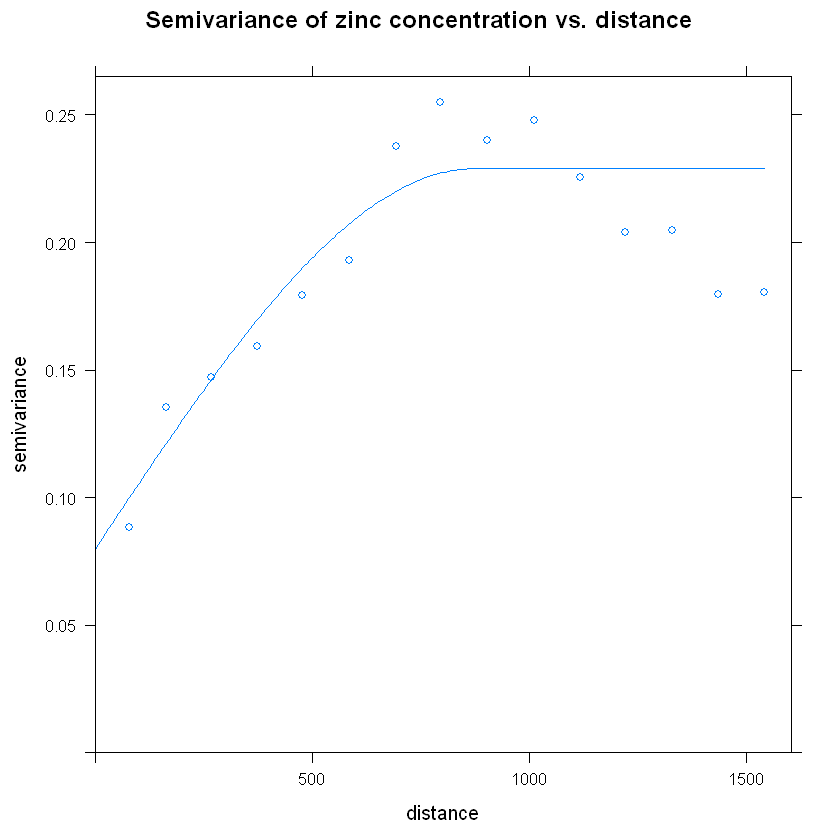

In [40]:
#This graph is for the question on the website
#It shows that this plot and the copper plot are similarly well fit
zinc.vgm = variogram(logZinc ~ sqrtDist, meuse)
zinc.vgm.fit = fit.variogram(zinc.vgm, model = vgm(1, "Sph", 900, 1))
plot(zinc.vgm, zinc.vgm.fit, main = "Semivariance of zinc concentration vs. distance")

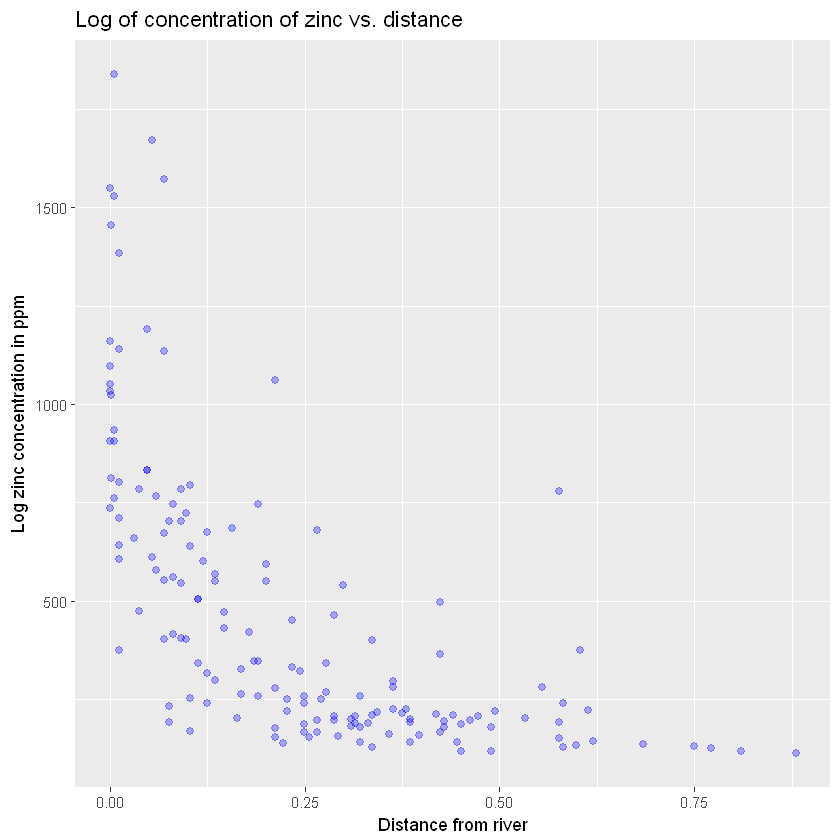

In [37]:
ggplot(data.frame(meuse), aes(dist, zinc)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3) +
  ggtitle('Log of concentration of zinc vs. distance') +
  ylab('Log zinc concentration in ppm') +
  xlab('Distance from river')

In [23]:
meuse$logZinc = log(meuse$zinc)

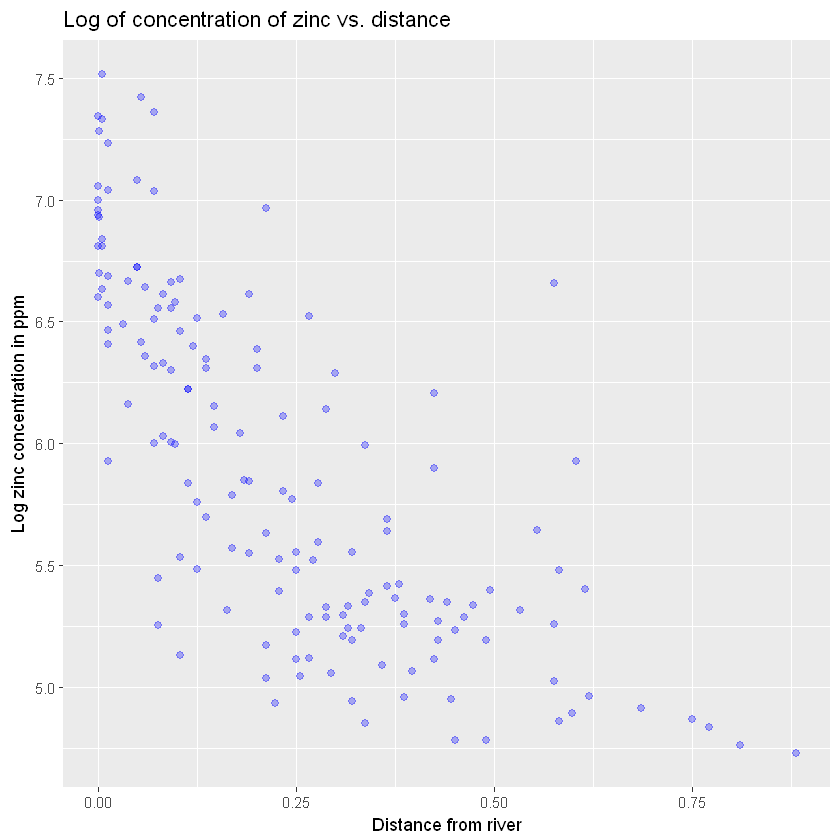

In [25]:
ggplot(data.frame(meuse), aes(dist, logZinc)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3) +
  ggtitle('Log of concentration of zinc vs. distance') +
  ylab('Log zinc concentration in ppm') +
  xlab('Distance from river')

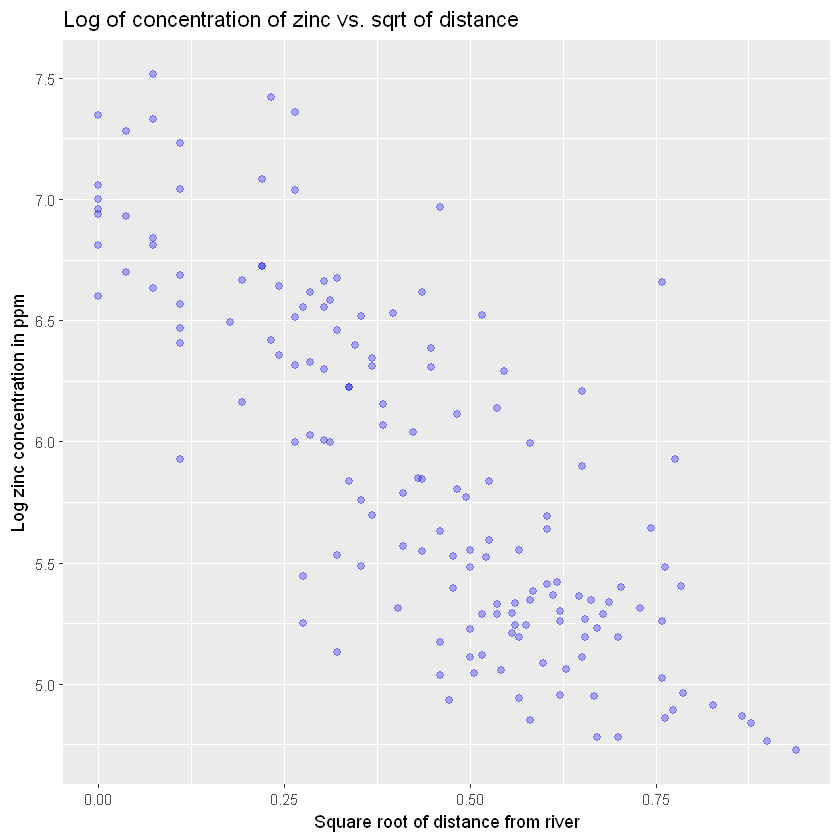

In [26]:
ggplot(data.frame(meuse), aes(sqrtDist, logZinc)) + 
  geom_point(size = 2, color = 'blue', alpha = 0.3)+
  ggtitle('Log of concentration of zinc vs. sqrt of distance') +
  ylab('Log zinc concentration in ppm') +
  xlab('Square root of distance from river')

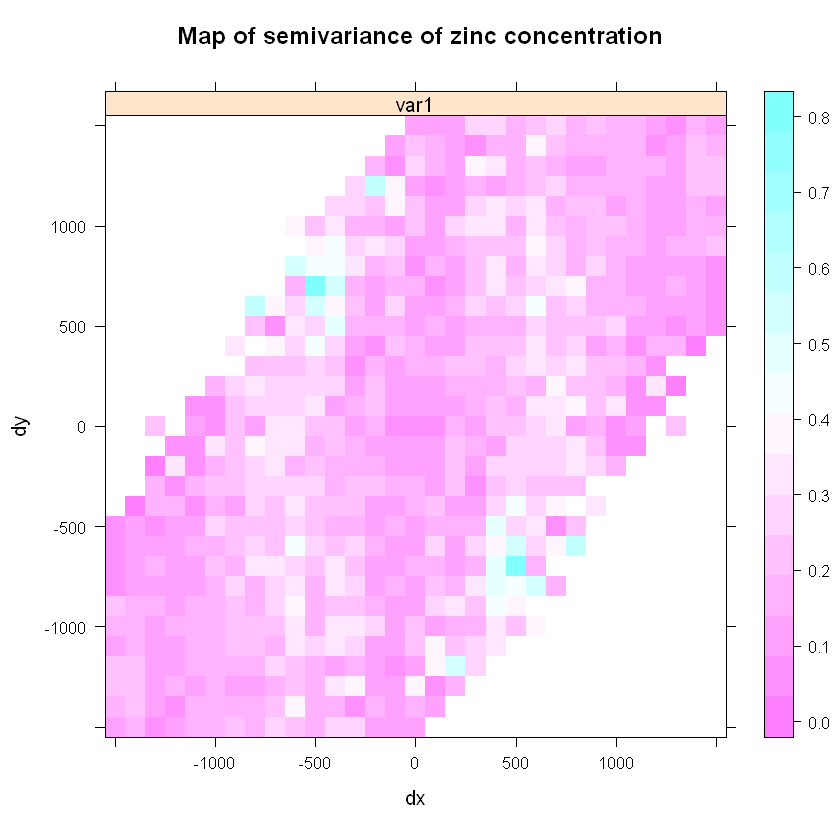

In [24]:
zinc.vgm.map = variogram(logZinc ~ sqrtDist, meuse, cutoff = 1500, width = 100, map = TRUE)
plot(zinc.vgm.map, threshold = 5, main = "Map of semivariance of zinc concentration")

## Interpolate the Copper Concentration

Having computed and evaluated the variogram, you will now interpolate the values of copper concentration. You will use the kriging method to interpolate the irregularly sampled copper concentration to a regular grid.  

As a first step, you will create a map of the grid used for interpolation. More specifically, you will create an image showing distance from the river on the grid. Execute the code in the cell below to view this map. 

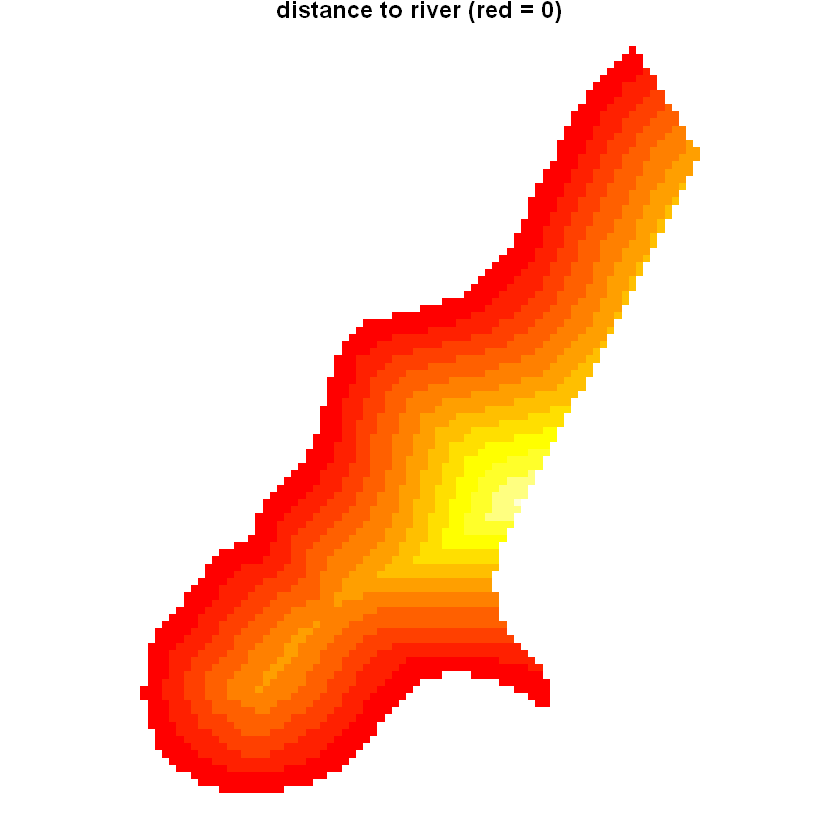

In [27]:
par(mar = c(0.7,0.7,0.7,0.7))
image(meuse.grid["dist"])
title("distance to river (red = 0)")

The Meuse River runs from the upper right to the lower left of the diagram, curves toward the upper right, and finally toward the lower right. Examine this map and note that, as expected, the lowest distance is near the curve of the river and the greatest distances are near the center (shown in yellow). 

Next, using the distance on the grid you will use the **iwd** function to compute the inverse weighted distance of copper concentration. Execute the code in the cell below to compute the IWD of copper concentration. 

In [20]:
copper.idw = idw(copper ~ 1, meuse, meuse.grid)
names(copper.idw)

[inverse distance weighted interpolation]


[1] "var1.pred" "var1.var"

Notice that the result has two columns. One showing the IWD and the other showing the variance of the computed IWD. 

You will now create a map of the IWD of the copper concentration by executing the code in the cell below.  

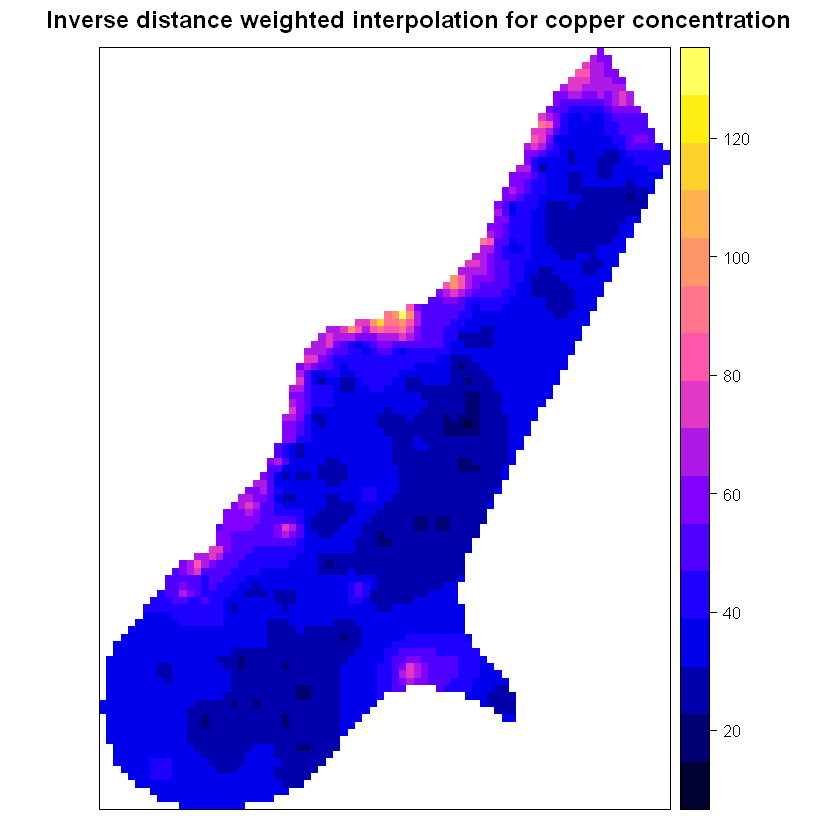

In [21]:
par(mar = c(0.7,0.7,0.7,0.7))
spplot(copper.idw["var1.pred"], main = "Inverse distance weighted interpolation for copper concentration")

Examine this map. Notice that the IWD of copper concentration has a few hot spots (high values) along the path of the river. There are areas of low IWD farther from the river. While this map provides some interesting insights into spatial distribution of copper pollution, it does not represent an interpolation.

To interpolate the concentration of log of copper onto the grid you will use the kriging method. Kriging uses the spatial dependency structure of the variogram you computed perviously. Execute the code in the cell below to compute the kriged concentration of copper and plot it on a map. 

[using ordinary kriging]


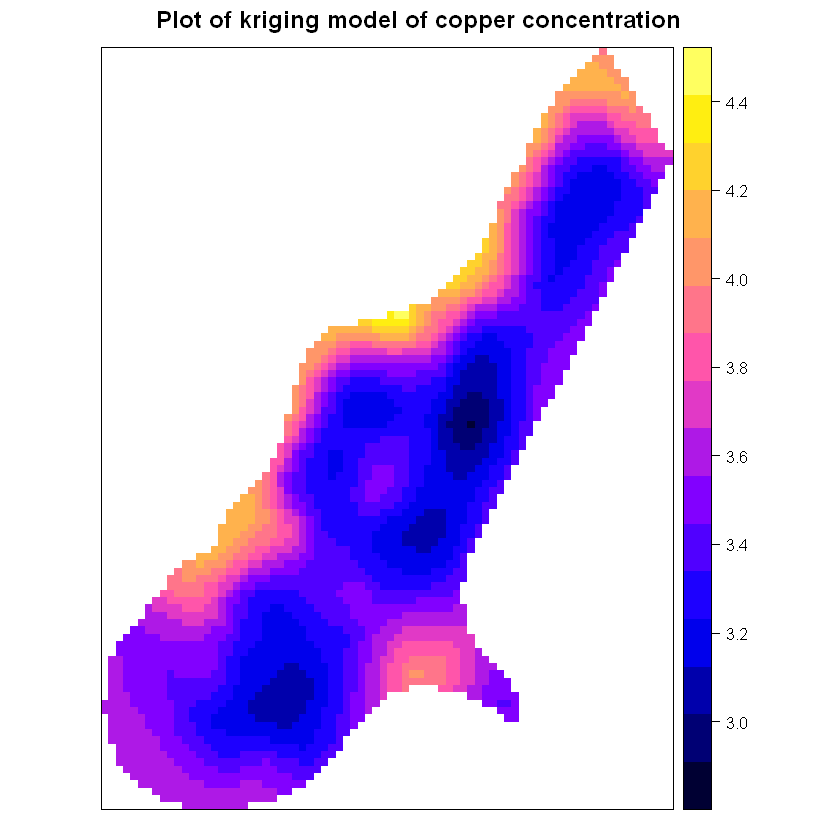

In [22]:
copper.kriged = krige(logCopper ~ 1, meuse, meuse.grid, model = copper.vgm.fit)
spplot(copper.kriged["var1.pred"], main ="Plot of kriging model of copper concentration")

Examine the map of kriged copper concentration. As expected, the highest concentrations of copper pollution are near the Meuse River. There are areas of low concentration in areas far from the river.  

****
#### Exercise

You must now compute and plot the map of kriged zinc concentration to answer the following questions:
- How is the kriged concentration of zinc similar to the kriged concentration of copper?

    They have similar hotspots along the NW edge of the river, and in the lower right elbow.

- How is the kriged concentration of zinc different from the kriged concentration of copper?

    The zinc has larger spots of lower concentration, i.e. bigger black spots. The color scales of the two indicate that zinc has a much broader range of concentrations, and even the lows are higher than the hgihest copper hotspots

In the cell below, use code similar to the examples provided above to compute and plot the kriged zinc concentration 

****


In [31]:
zinc.vgm = variogram(logZinc ~ sqrtDist, meuse)
zinc.vgm.fit = fit.variogram(zinc.vgm, model = vgm(1, "Sph", 900, 1))

[using ordinary kriging]


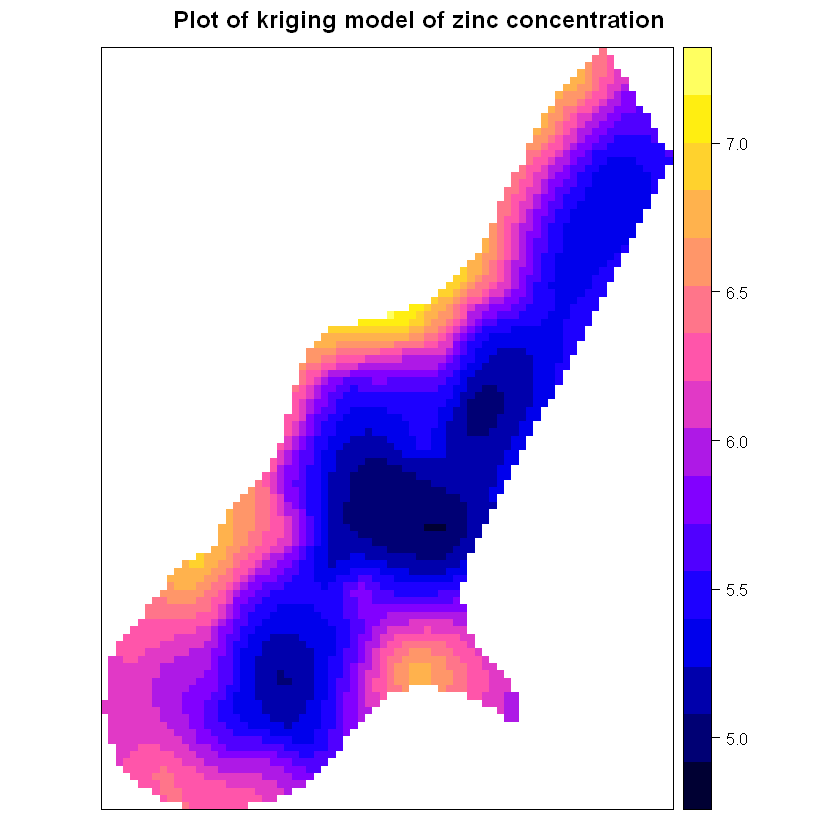

In [32]:
zinc.kriged = krige(logZinc ~ 1, meuse, meuse.grid, model = zinc.vgm.fit)
spplot(zinc.kriged["var1.pred"], main ="Plot of kriging model of zinc concentration")

## Summary

In this lab you have done the following:

- Examined properties of the SpatialPixelsDataFrame.
- Mapped spatially sampled data.
- Determined the variogram structure of spatial data.
- Interpolated the spatail data values using kriging. 